# 5. Multimodal characterization of exRNA environment

In this notebook we aim to contextualize the position of exRNA in the context of imaging stainings we might have present in the data

## Import packages

In [ ]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata as sd

import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Pairing extracellular RNA with image intensities
We read the sdata cropped object we created in previous steps

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/mousebrain_prime_crop_communication.zarr"
output_path = "/media/sergio/Discovair_final/analysis_crop"
sdata = sd.read_zarr(xenium_path_cropped)

In [3]:
# this is temporary, since currently extracellular def is wrong on test data
transcripts = sdata["transcripts"].compute()  # type: ignore
transcripts["extracellular"] = ~transcripts["extracellular"]
sdata["transcripts"] = sd.models.PointsModel.parse(transcripts)

First, we filter xrna to just keep the analysis with relevant genes, using ``troutpy.pp.filter_xrna``

In [4]:
troutpy.pp.filter_xrna(sdata, min_logfoldratio_over_noise=4)

Next, we use the function ``troutpy.tl.image_intensities_per_transcript`` to identify,  the intensities of the images (protein stainings or others) in the position of each xRNA. This will be then useful to contextualize the location of exRNA

In [5]:
troutpy.tl.image_intensities_per_transcript(
    sdata, image_key="morphology_focus", scale="scale0", transcript_key="transcripts", extracellular=True, copy=False
)

After the assigment, we can then visualize the intensities retrieved in the space to double check that it went as expected. To keep the code more intiutive, we will save the intensity values in a new adata file ``ad`` which will be used from now on to be processed

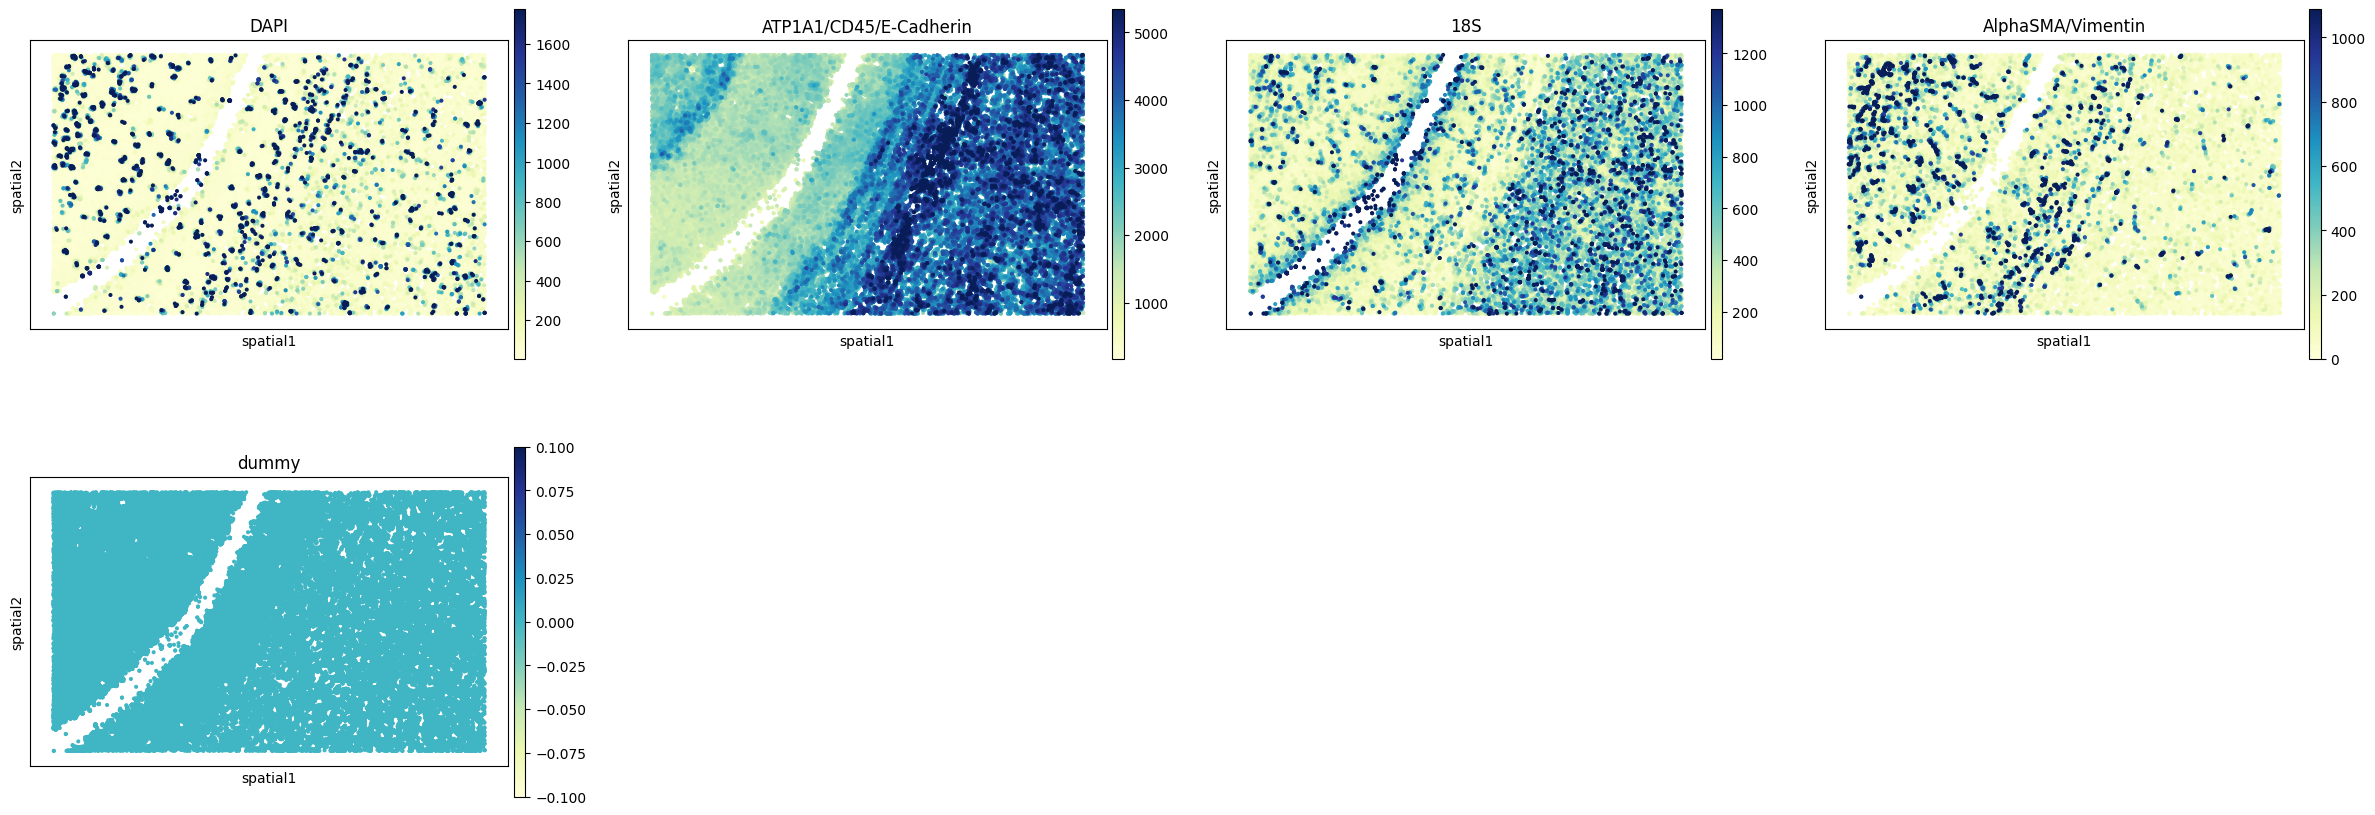

In [79]:
ad = sdata["image_intensity_per_transcript"]
sc.pl.spatial(ad, color=ad.var.index, spot_size=10, cmap="YlGnBu", vmax="p99", ncols=4)

Following this, we will cluster each transcript based on its extracellular profile using scanpy

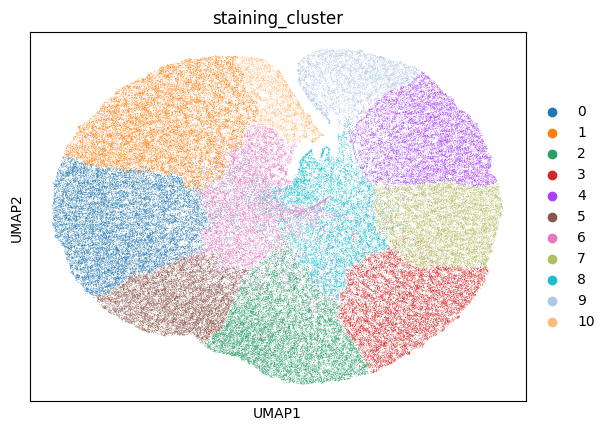

In [81]:
sc.pp.neighbors(ad)
sc.tl.leiden(ad, resolution=0.1, key_added="staining_cluster")
sc.tl.umap(ad)
sc.pl.umap(ad, color="staining_cluster")

We can next visualize the spatial distribution of the resulting staining-based clusters, as well as their composition

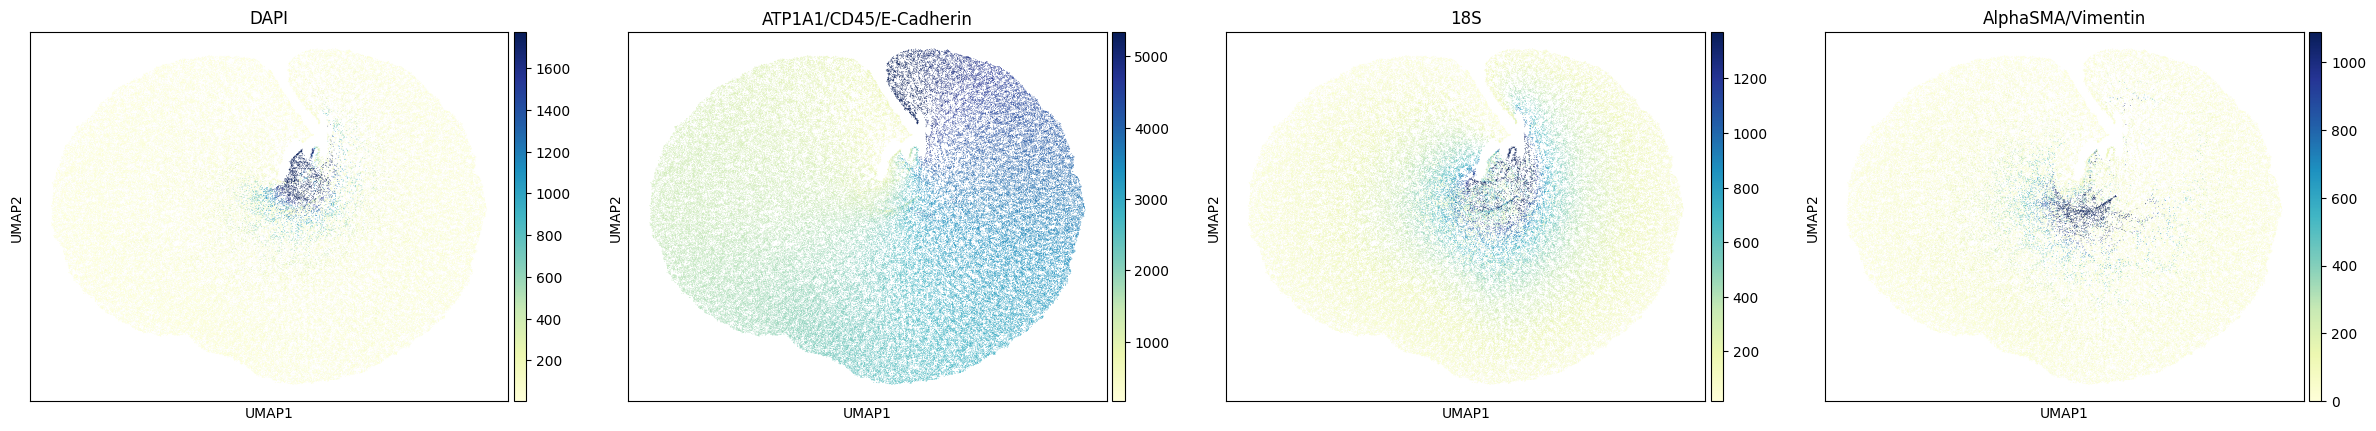

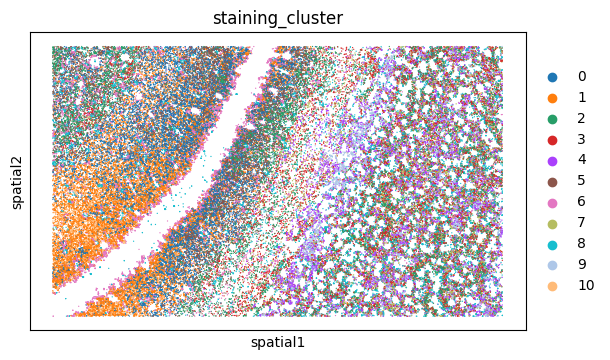

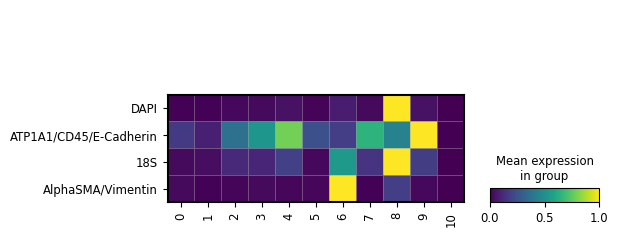

In [82]:
sc.pl.umap(ad, color=ad.var.index[:-1], cmap="YlGnBu", vmax="p99", ncols=4)
sc.pl.spatial(ad, color="staining_cluster", spot_size=3)
sc.pl.matrixplot(ad, ad.var.index[:-1], groupby="staining_cluster", standard_scale="var", swap_axes=True)

Next, we plot the presence of each transcript on each cluster, identifying clear patterns

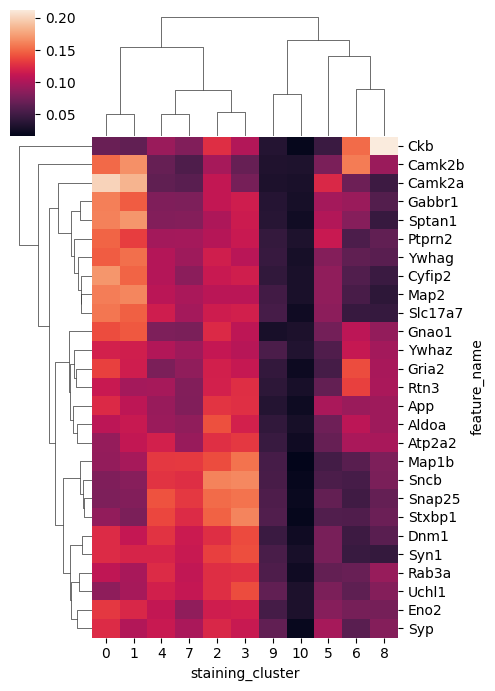

In [84]:
env_by_gene = pd.crosstab(ad.obs["feature_name"], ad.obs["staining_cluster"])
env_by_gene = env_by_gene.div(env_by_gene.sum(axis=1), axis=0)
sns.clustermap(env_by_gene, figsize=(5, 7))

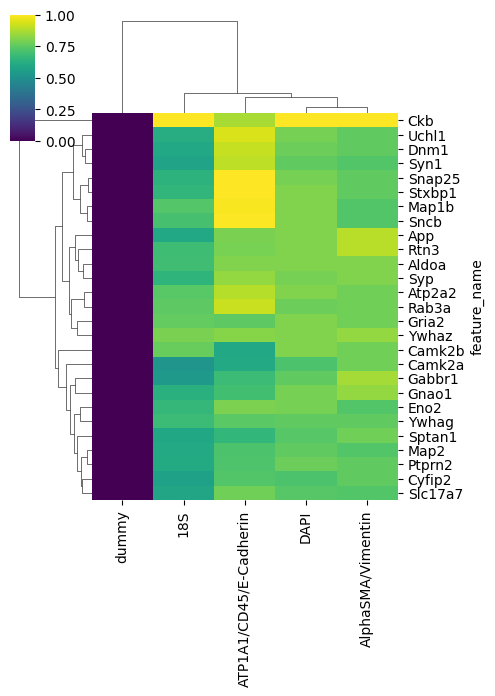

In [88]:
exp = ad.to_df()
exp["feature_name"] = ad.obs["feature_name"]
mean_intensities = exp.groupby("feature_name").median()
mean_intensities = mean_intensities.div(mean_intensities.max(axis=0))
sns.clustermap(mean_intensities.fillna(0), cmap="viridis", figsize=(5, 7))

## Save spatialdata as zarr 

In [89]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/mousebrain_prime_crop_with_image_quantification.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Meninges/troutpy/mousebrain_prime_crop_with_image_quantification.zarr).   
         Please see the documentation of `is_self_contained()` to understand the implications of working with      
         SpatialData objects that are not self-contained.                                                          
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Meninges/troutpy/mousebrain_prime_crop_communication.zarr the new file path:                
         /media/sergio/Meninges/troutpy/mousebrain_prime_crop_with_image_quantification.zarr                       
